In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [8]:
import torch
import torch.nn as nn
from neuralop.models import FNO2d
from neuralop.data.datasets import DarcyDataset, NavierStokesDataset
from torch.utils.data import DataLoader
import numpy as np
import copy
from tqdm import tqdm

def get_dataset_loader(dataset_name, batch_size):
    if dataset_name == "DarcyFlow":
        dataset = DarcyDataset(
            root_dir='./data/darcy',
            n_train=1000, n_tests=[100],
            batch_size=batch_size, test_batch_sizes=[batch_size],
            train_resolution=64, test_resolutions=[64],
            download=True
        )
        train_loader = DataLoader(dataset.train_db, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset.test_dbs[64], batch_size=batch_size, shuffle=False)

    elif dataset_name == "NavierStokes":
        dataset = NavierStokesDataset(
            root_dir='./data/navier_stokes',
            n_train=1000, n_tests=[100],
            batch_size=batch_size, test_batch_sizes=[batch_size],
            train_resolution=128, test_resolutions=[128],
            download=True
        )
        train_loader = DataLoader(dataset.train_db, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset.test_dbs[128], batch_size=batch_size, shuffle=False)

    elif dataset_name == "CarCFD":
        dataset = CarCFDDataset(
            root_dir='./data/car_cfd/processed-car-pressure-data/',
            n_train=1000, n_test=200,
            query_res=[32, 32, 32],
            download=False
        )
        train_loader = dataset.train_loader
        test_loader = dataset.test_loader

    else:
        raise ValueError(f"Dataset {dataset_name} not supported yet.")

    sample_batch = next(iter(train_loader))
    in_channels = sample_batch["x"].shape[1]
    out_channels = sample_batch["y"].shape[1]

    return train_loader, test_loader, in_channels, out_channels
    
# 1. 모델 정의
#####################
# Model definitions
#####################

# FNO
class FNO(nn.Module):
    def __init__(self, n_modes_height=12, n_modes_width=12, hidden_channels=64, in_channels=1, out_channels=1, device="cuda"):
        super().__init__()
        self.fno = FNO2d(n_modes_height=n_modes_height,
        n_modes_width=n_modes_width,
        hidden_channels=hidden_channels,
        in_channels=in_channels,
        out_channels=out_channels,
        lifting_channels=hidden_channels).to(device)

    def forward(self, x):
        return self.fno(x)

# UNet
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, hidden_channels=64, device="cuda"):
        super(UNet, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        # Encoder
        self.enc1 = conv_block(in_channels, hidden_channels)
        self.enc2 = conv_block(hidden_channels, hidden_channels*2)
        self.enc3 = conv_block(hidden_channels*2, hidden_channels*4)
        
        # Middle
        self.middle = conv_block(hidden_channels*4, hidden_channels*8)
        
        # Decoder
        self.upconv3 = nn.ConvTranspose2d(hidden_channels*8, hidden_channels*4, 2, stride=2)
        self.dec3 = conv_block(hidden_channels*8, hidden_channels*4)
        self.upconv2 = nn.ConvTranspose2d(hidden_channels*4, hidden_channels*2, 2, stride=2)
        self.dec2 = conv_block(hidden_channels*4, hidden_channels*2)
        self.upconv1 = nn.ConvTranspose2d(hidden_channels*2, hidden_channels, 2, stride=2)
        self.dec1 = conv_block(hidden_channels*2, hidden_channels)
        
        # Final layer
        self.final = nn.Conv2d(hidden_channels, out_channels, 1)
        
        self.pool = nn.MaxPool2d(2)
        
        self.to(device)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        
        # Middle
        m = self.middle(self.pool(e3))
        
        # Decoder
        d3 = self.upconv3(m)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        # Final
        return self.final(d1)

# DeepONet
class MLP(nn.Module):
    def __init__(self, layers, activation=nn.ReLU):
        super().__init__()
        if len(layers) < 2:
            raise ValueError("At least two layers (input and output) are required.")
        self.model = nn.Sequential()
        for i in range(len(layers) - 2):
            self.model.add_module(f'fc{i}', nn.Linear(layers[i], layers[i+1]))
            self.model.add_module(f'act{i}', activation())
        self.model.add_module('fc_out', nn.Linear(layers[-2], layers[-1]))

    def forward(self, x):
        return self.model(x)

class DeepONet(nn.Module):
    def __init__(self, input_dim=64*64, trunk_dim=2, latent_dim=100, H=64, W=64):
        super().__init__()
        self.H, self.W = H, W
        if input_dim != H * W:
            raise ValueError(f"input_dim ({input_dim}) must equal H*W ({H*W})")

        self.branch_net = MLP([input_dim, 200, 200, latent_dim])
        self.trunk_net = MLP([trunk_dim, 200, 200, latent_dim])

        # 좌표 그리드 생성 및 저장
        grid_x = torch.linspace(-1, 1, H)
        grid_y = torch.linspace(-1, 1, W)
        X, Y = torch.meshgrid(grid_x, grid_y, indexing='ij')  # [H, W]
        coords = torch.stack([X, Y], dim=-1).view(-1, 2)       # [H*W, 2]
        self.register_buffer("coords", coords)

    def forward(self, a_field):
        B, C, H, W = a_field.shape
        if C != 1:
            raise ValueError(f"Expected channel dimension to be 1, got {C}")
        if H != self.H or W != self.W:
            raise ValueError(f"Expected spatial dimensions ({self.H}, {self.W}), got ({H}, {W})")

        a_flat = a_field.view(B, -1)  # [B, H*W]
        branch_out = self.branch_net(a_flat)  # [B, latent_dim]

        coords = self.coords  # [H*W, 2]
        trunk_out = self.trunk_net(coords)  # [H*W, latent_dim]
        trunk_out = trunk_out.expand(B, -1, -1)  # [B, H*W, latent_dim]
        branch_out = branch_out.unsqueeze(1)  # [B, 1, latent_dim]

        out = torch.einsum('bmd,bnd->bn', branch_out, trunk_out)  # [B, H*W]
        return out.view(B, 1, H, W)
        
# 2. Fine-tuning 함수
def fine_tune(model, optimizer, criterion, train_loader, lr, device):
    model.train()
    # all_outputs = []
    # all_targets = []
    train_loss = 0.0
    

    for batch in train_loader:
        inputs, targets = batch["x"].to(device), batch["y"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # all_outputs.append(outputs.detach().cpu())
        # all_targets.append(targets.detach().cpu())
        train_loss += loss.item()

    # 전체 상대오차 계산
    # outputs_all = torch.cat(all_outputs, dim=0)
    # targets_all = torch.cat(all_targets, dim=0)
    # rel_error = torch.norm(outputs_all - targets_all) / torch.norm(targets_all)

    return model, copy.deepcopy(model.state_dict()), train_loss / len(train_loader)

def studygroup(model1, model2, optimizer1, optimizer2, criterion, train_loader, lr, device):
    model1.train()
    # all_outputs1 = []
    # all_targets1 = []
    train_loss1 = 0.0
    model2.train()
    # all_outputs2 = []
    # all_targets2 = []
    train_loss2 = 0.0
    
    for batch in train_loader:
        inputs, targets = batch["x"].to(device), batch["y"].to(device)
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        outputs1 = model1(inputs)
        outputs2 = model2(inputs)
        loss1 = criterion(outputs1, targets)
        loss2 = criterion(outputs2, targets)
        # total_loss1 += loss1.item()
        # total_loss2 += loss2.item()
        
        gap = torch.abs(outputs1 - targets) > torch.abs(outputs2 - targets)
        sign = torch.sign(outputs1 - targets) != torch.sign(outputs2 - targets)
        index1 = torch.where(torch.logical_and(gap, sign))
        index2 = torch.where(torch.logical_and(~gap, sign))
        index3 = torch.where(~sign)
        
        if index1[0].numel() > 0:
            loss1 = criterion(outputs1[index1[0], index1[1], index1[2], index1[3]], outputs2[index1[0], index1[1], index1[2], index1[3]].detach())
        if index3[0].numel() > 0:
            loss1 += criterion(outputs1[index3[0], index3[1], index3[2], index3[3]], targets[index3[0], index3[1], index3[2], index3[3]])
        loss1.backward()
        optimizer1.step()
        
        if index2[0].numel() > 0:
            loss2 = criterion(outputs2[index2[0], index2[1], index2[2], index2[3]], outputs1[index2[0], index2[1], index2[2], index2[3]].detach())
        if index3[0].numel() > 0:
            loss2 += criterion(outputs2[index3[0], index3[1], index3[2], index3[3]], targets[index3[0], index3[1], index3[2], index3[3]])        
        loss2.backward()
        optimizer2.step()
        
        # all_outputs1.append(outputs1.detach().cpu())
        # all_targets1.append(targets.detach().cpu())
        # all_outputs2.append(outputs2.detach().cpu())
        # all_targets2.append(targets.detach().cpu())
        train_loss1 += loss1.item()
        train_loss2 += loss2.item()
        
    # outputs_all1 = torch.cat(all_outputs1, dim=0)
    # targets_all1 = torch.cat(all_targets1, dim=0)
    # rel_error1 = torch.norm(outputs_all1 - targets_all1) / torch.norm(targets_all1)
    # outputs_all2 = torch.cat(all_outputs2, dim=0)
    # targets_all2 = torch.cat(all_targets2, dim=0)
    # rel_error2 = torch.norm(outputs_all2 - targets_all2) / torch.norm(targets_all2)
    return model1, model2, copy.deepcopy(model1.state_dict()), copy.deepcopy(model2.state_dict()), train_loss1 / len(train_loader), train_loss2 / len(train_loader)

def mutualstudy(model1, model2, optimizer1, optimizer2, criterion, train_loader, lr, device):    
    for batch in train_loader:
        model1_next = copy.deepcopy(model1).to(device)
        model1_next.train()
        train_loss1 = 0.0
        model2_next = copy.deepcopy(model2).to(device)
        model2_next.train()
        train_loss2 = 0.0
        optimizer1 = torch.optim.Adam(model1_next.parameters(), lr=1e-3, weight_decay=1e-4)
        optimizer2 = torch.optim.Adam(model2_next.parameters(), lr=1e-3, weight_decay=1e-4)
        
        inputs = batch["x"].to(device) #, batch["y"].to(device)
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        outputs1 = model1_next(inputs)
        outputs2 = model2_next(inputs)
        loss1 = criterion(outputs1, outputs2.detach())
        loss2 = criterion(outputs2, outputs1.detach())
        
        loss1.backward()
        optimizer1.step()
      
        loss2.backward()
        optimizer2.step()

        out1 = model1(inputs)
        out2 = model2(inputs)
        out1_next = model1_next(inputs)
        out2_next = model2_next(inputs)

        loss_1 = criterion(out1, out2)
        loss_2 = criterion(out1_next, out2_next)
        loss_3 = criterion(out1, out2_next)
        loss_4 = criterion(out1_next, out2)
        losses = [loss_1, loss_2, loss_3, loss_4]
        if min(losses) == loss_1:
            model1, model2 = model1, model2
        elif min(losses) == loss_2:
            model1, model2 = model1_next, model2_next
        elif min(losses) == loss_3:
            model1, model2 = model1, model2_next
        else:
            model1, model2 = model1_next, model2
        train_loss1 += min(losses).item()
        train_loss2 += min(losses).item()

    return model1, model2, copy.deepcopy(model1.state_dict()), copy.deepcopy(model2.state_dict()), train_loss1 / len(train_loader), train_loss2 / len(train_loader)

# 7. 평가 함수
def evaluate(model, test_loader, device):
    criterion = nn.MSELoss()
    model.eval()
    # all_outputs = []
    # all_targets = []
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch["x"].to(device), batch["y"].to(device)
            outputs = model(inputs)
            # all_outputs.append(outputs.cpu())
            # all_targets.append(targets.cpu())
            test_loss += criterion(outputs, targets).item()
    # outputs_all = torch.cat(all_outputs, dim=0)
    # targets_all = torch.cat(all_targets, dim=0)
    # rel_error = torch.norm(outputs_all - targets_all) / torch.norm(targets_all)
    return test_loss / len(test_loader)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Darcy Flow 데이터셋 로드 및 입력 채널 확인
train_loader, test_loader, in_channels, out_channels = get_dataset_loader("NavierStokes", batch_size=16)

/home/geunseopark/anaconda3/envs/PGS_TORCH/lib/python3.12/site-packages/neuralop/data/datasets/pt_dataset.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.l

Loading test db for resolution 128 with 100 samples 


/home/geunseopark/anaconda3/envs/PGS_TORCH/lib/python3.12/site-packages/neuralop/data/datasets/pt_dataset.py:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.

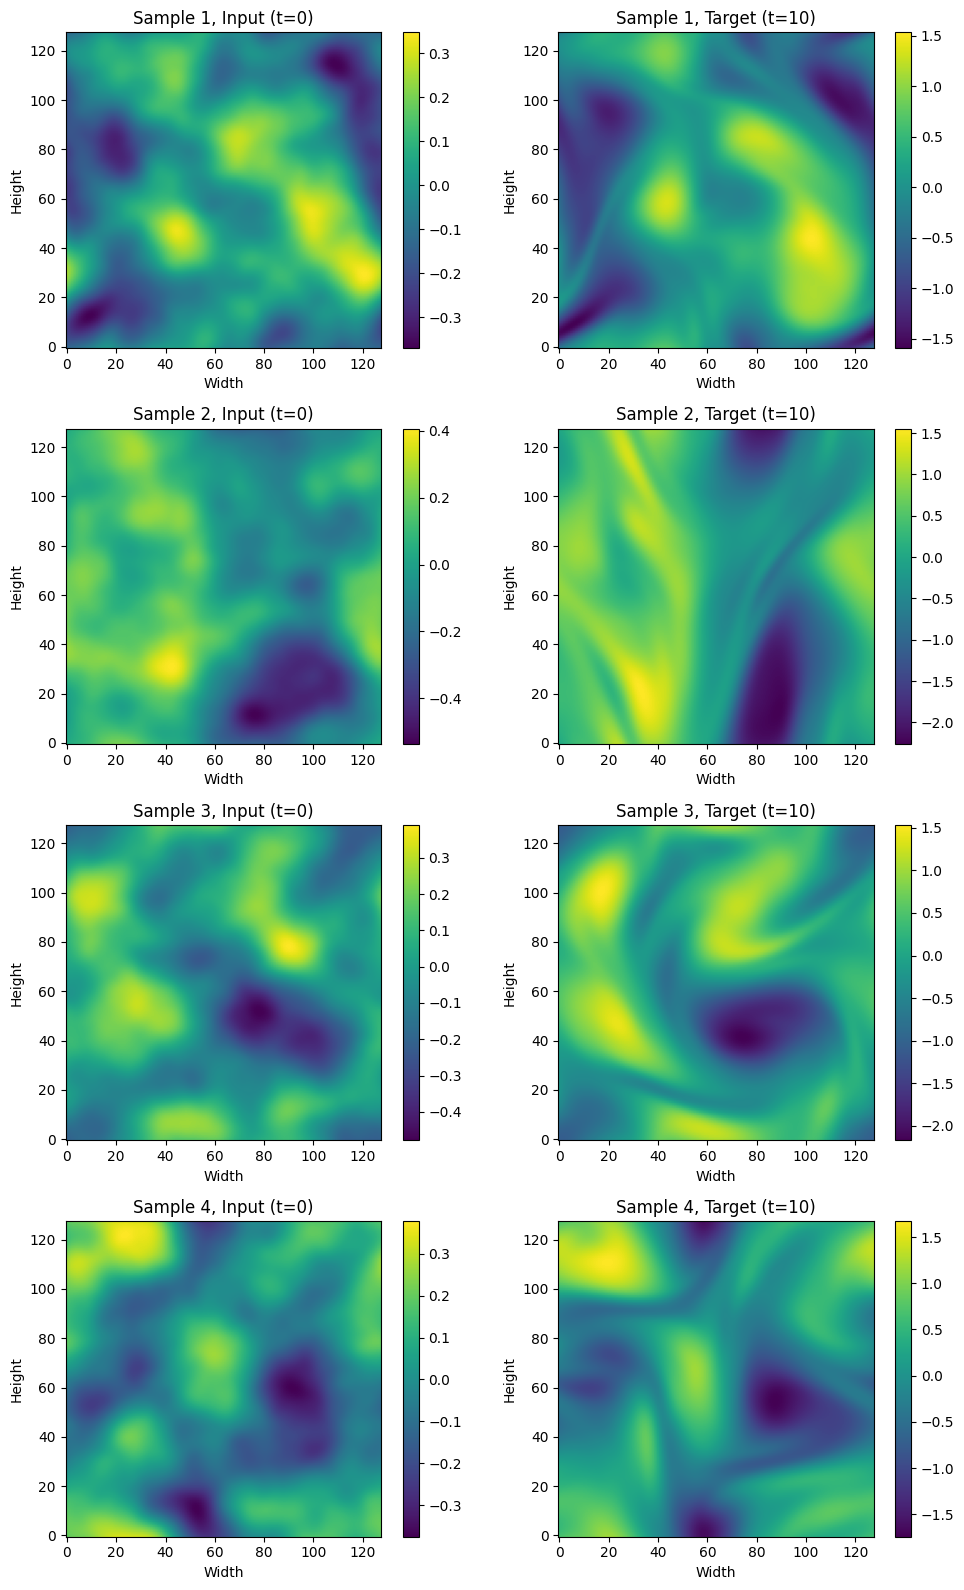

In [4]:
import matplotlib.pyplot as plt
# 첫 번째 배치 가져오기
batch = next(iter(train_loader))
inputs = batch['x']  # Shape: (16, 1, 128, 128)
targets = batch['y']  # Shape: (16, 1, 128, 128)

# 시각화를 위해 NumPy 배열로 변환
inputs = inputs.cpu().numpy()  # (16, 1, 128, 128)
targets = targets.cpu().numpy()  # (16, 1, 128, 128)

# 시각화: 첫 4개 샘플의 입력(t=0)과 타겟(t=10)
num_samples = 4
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))

for i in range(num_samples):
    # 입력 데이터 (t=0)
    ax = axes[i, 0]
    im = ax.imshow(inputs[i, 0], cmap='viridis', origin='lower')
    ax.set_title(f'Sample {i+1}, Input (t=0)')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    fig.colorbar(im, ax=ax)
    
    # 타겟 데이터 (t=10)
    ax = axes[i, 1]
    im = ax.imshow(targets[i, 0], cmap='viridis', origin='lower')
    ax.set_title(f'Sample {i+1}, Target (t=10)')
    ax.set_xlabel('Width')
    ax.set_ylabel('Height')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


In [5]:
# FNO 모델 초기화
pretrained_model1 = FNO(in_channels=in_channels, device=device)
pretrained_model2 = UNet(in_channels=in_channels, out_channels=out_channels, hidden_channels=64).to(device)
pretrained_model3 = DeepONet(input_dim=128*128, H=128, W=128).to(device)

epochs = 1000
seed=0
torch.cuda.empty_cache()
torch.manual_seed(seed)

model1 = copy.deepcopy(pretrained_model1).to(device)
model2 = copy.deepcopy(pretrained_model2).to(device)
model3 = copy.deepcopy(pretrained_model3).to(device)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
fine_tuned_models1 = []
train_loss_save1 = []
test_loss_save1 = []
for epoch in tqdm(range(epochs)):
    model1, weight1, loss1 = fine_tune(model1, optimizer1, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save1.append(loss1)
    # fine_tuned_models1.append(weight1)
    test_loss1 = evaluate(model1, test_loader, device)
    test_loss_save1.append(test_loss1)
    if epoch == 0:
        best_model1 = copy.deepcopy(model1)
        best_weight1 = copy.deepcopy(weight1)
    elif test_loss1 == min(test_loss_save1):
        best_model1 = copy.deepcopy(model1)
        best_weight1 = copy.deepcopy(weight1)

torch.cuda.empty_cache()
# fine_tuned_models2 = []
train_loss_save2 = []
test_loss_save2 = []
for epoch in tqdm(range(epochs)):
    model2, weight2, loss2 = fine_tune(model2, optimizer2, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save2.append(loss2)
    # fine_tuned_models2.append(weight2)
    test_loss2 = evaluate(model2, test_loader, device)
    test_loss_save2.append(test_loss2)
    if epoch == 0:
        best_model2 = copy.deepcopy(model2)
        best_weight2 = copy.deepcopy(weight2)
    elif test_loss2 == min(test_loss_save2):
        best_model2 = copy.deepcopy(model2)
        best_weight2 = copy.deepcopy(weight2)

torch.cuda.empty_cache()
# fine_tuned_models3 = []
train_loss_save3 = []
test_loss_save3 = []
for epoch in tqdm(range(epochs)):
    model3, weight3, loss3 = fine_tune(model3, optimizer3, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save3.append(loss3)
    # fine_tuned_models3.append(weight3)
    test_loss3 = evaluate(model3, test_loader, device)
    test_loss_save3.append(test_loss3)
    if epoch == 0:
        best_model3 = copy.deepcopy(model3)
        best_weight3 = copy.deepcopy(weight3)
    elif test_loss3 == min(test_loss_save3):
        best_model3 = copy.deepcopy(model3)
        best_weight3 = copy.deepcopy(weight3)

100%|███████████████████████████████████████| 1000/1000 [02:37<00:00,  6.34it/s]


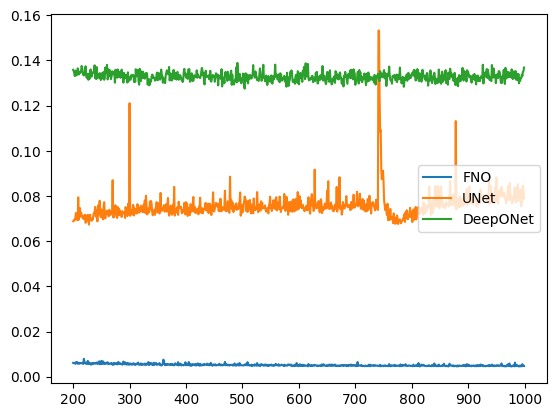

In [6]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save1[200:], label='FNO')
plt.plot(range(1000)[200:], test_loss_save2[200:], label='UNet')
plt.plot(range(1000)[200:], test_loss_save3[200:], label='DeepONet')
plt.legend()
plt.show()

In [9]:
torch.cuda.empty_cache()
# Study Group 학습
model12 = copy.deepcopy(pretrained_model1).to(device)
model21 = copy.deepcopy(pretrained_model2).to(device)
optimizer12 = torch.optim.Adam(model12.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer21 = torch.optim.Adam(model21.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models11 = []
train_loss_save12 = []
test_loss_save12 = []
# fine_tuned_models22 = []
train_loss_save21 = []
test_loss_save21 = []
for epoch in tqdm(range(epochs-200)):
    model12, model21, weight12, weight21, loss12, loss21 = studygroup(model12, model21, optimizer12, optimizer21, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save12.append(loss12)
    # fine_tuned_models12.append(weight12)
    test_loss12 = evaluate(model12, test_loader, device)
    test_loss_save12.append(test_loss12)
    if epoch == 0:
        best_model12 = copy.deepcopy(model12)
        best_weight12 = copy.deepcopy(weight12)
    elif test_loss12 == min(test_loss_save12):
        best_model12 = copy.deepcopy(model12)
        best_weight12 = copy.deepcopy(weight12)
        
    train_loss_save21.append(loss21)
    # fine_tuned_models21.append(weight21)
    test_loss21 = evaluate(model21, test_loader, device)
    test_loss_save21.append(test_loss21)
    if epoch == 0:
        best_model21 = copy.deepcopy(model21)
        best_weight21 = copy.deepcopy(weight21)
    elif test_loss21 == min(test_loss_save21):
        best_model21 = copy.deepcopy(model21)
        best_weight21 = copy.deepcopy(weight21)

for epoch in tqdm(range(200)):
    model12, model21, weight12, weight21, loss12, loss21 = mutualstudy(model12, model21, optimizer12, optimizer21, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save12.append(loss12)
    # fine_tuned_models12.append(weight12)
    test_loss12 = evaluate(model12, test_loader, device)
    test_loss_save12.append(test_loss12)
    if epoch == 0:
        best_model12 = copy.deepcopy(model12)
        best_weight12 = copy.deepcopy(weight12)
    elif test_loss12 == min(test_loss_save12):
        best_model12 = copy.deepcopy(model12)
        best_weight12 = copy.deepcopy(weight12)
        
    train_loss_save21.append(loss21)
    # fine_tuned_models21.append(weight21)
    test_loss21 = evaluate(model21, test_loader, device)
    test_loss_save21.append(test_loss21)
    if epoch == 0:
        best_model21 = copy.deepcopy(model21)
        best_weight21 = copy.deepcopy(weight21)
    elif test_loss21 == min(test_loss_save21):
        best_model21 = copy.deepcopy(model21)
        best_weight21 = copy.deepcopy(weight21)


100%|█████████████████████████████████████████| 200/200 [18:44<00:00,  5.62s/it]


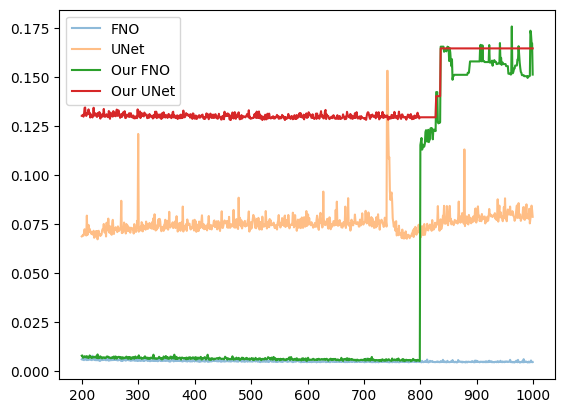

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save1[200:], label='FNO', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save2[200:], label='UNet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save12[200:], label='Our FNO')
plt.plot(range(1000)[200:], test_loss_save21[200:], label='Our UNet')
plt.legend()
plt.show()

In [11]:
# 평가
mse_base1 = evaluate(best_model1, test_loader, device)
mse_base2 = evaluate(best_model2, test_loader, device)
mse_study12 = evaluate(best_model12, test_loader, device)
mse_study21 = evaluate(best_model21, test_loader, device)

print(f"Model Base1 MSE: {mse_base1}")
print(f"Model Base2 MSE: {mse_base2}")
print(f"Model Study12 MSE: {mse_study12}")
print(f"Model Study21 MSE: {mse_study21}")

Model Base1 MSE: 0.00455215952492186
Model Base2 MSE: 0.06095441484025547
Model Study12 MSE: 0.11539584078959056
Model Study21 MSE: 0.12957595182316645


In [10]:
torch.cuda.empty_cache()
# Study Group 학습
model13 = copy.deepcopy(pretrained_model1).to(device)
model31 = copy.deepcopy(pretrained_model3).to(device)
optimizer13 = torch.optim.Adam(model13.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer31 = torch.optim.Adam(model31.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models13 = []
train_loss_save13 = []
test_loss_save13 = []
# fine_tuned_models31 = []
train_loss_save31 = []
test_loss_save31 = []
for epoch in tqdm(range(epochs)):
    model13, model31, weight13, weight31, loss13, loss31 = studygroup(model13, model31, optimizer13, optimizer31, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save13.append(loss13)
    # fine_tuned_models13.append(weight13)
    test_loss13 = evaluate(model13, test_loader, device)
    test_loss_save13.append(test_loss13)
    if epoch == 0:
        best_model13 = copy.deepcopy(model13)
        best_weight13 = copy.deepcopy(weight13)
    elif test_loss13 == min(test_loss_save13):
        best_model13 = copy.deepcopy(model13)
        best_weight13 = copy.deepcopy(weight13)
        
    train_loss_save31.append(loss31)
    # fine_tuned_models31.append(weight31)
    test_loss31 = evaluate(model31, test_loader, device)
    test_loss_save31.append(test_loss31)
    if epoch == 0:
        best_model31 = copy.deepcopy(model31)
        best_weight31 = copy.deepcopy(weight31)
    elif test_loss31 == min(test_loss_save31):
        best_model31 = copy.deepcopy(model31)
        best_weight31 = copy.deepcopy(weight31)


100%|███████████████████████████████████████| 1000/1000 [37:44<00:00,  2.26s/it]


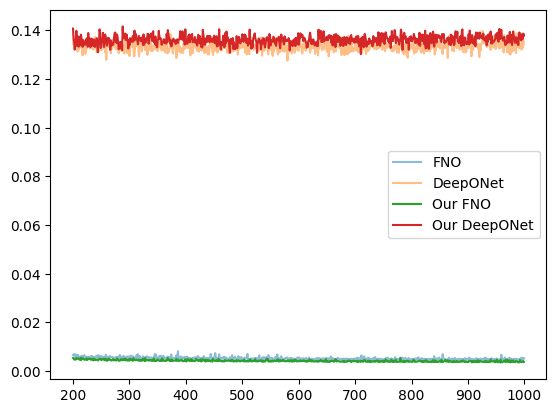

In [11]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save1[200:], label='FNO', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save3[200:], label='DeepONet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save13[200:], label='Our FNO')
plt.plot(range(1000)[200:], test_loss_save31[200:], label='Our DeepONet')
plt.legend()
plt.show()

In [12]:
# 평가
mse_base1 = evaluate(best_model1, test_loader, device)
mse_base3 = evaluate(best_model3, test_loader, device)
mse_study13 = evaluate(best_model13, test_loader, device)
mse_study31 = evaluate(best_model31, test_loader, device)

print(f"Model Base1 MSE: {mse_base1}")
print(f"Model Base3 MSE: {mse_base3}")
print(f"Model Study13 MSE: {mse_study13}")
print(f"Model Study31 MSE: {mse_study31}")

Model Base1 MSE: 0.004527100095791476
Model Base3 MSE: 0.12753387753452575
Model Study13 MSE: 0.0035726865088301046
Model Study31 MSE: 0.12986443936824799


In [13]:
torch.cuda.empty_cache()
# Study Group 학습
model23 = copy.deepcopy(pretrained_model2).to(device)
model32 = copy.deepcopy(pretrained_model3).to(device)
optimizer23 = torch.optim.Adam(model23.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer32 = torch.optim.Adam(model32.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models23 = []
train_loss_save23 = []
test_loss_save23 = []
# fine_tuned_models32 = []
train_loss_save32 = []
test_loss_save32 = []
for epoch in tqdm(range(epochs)):
    model23, model32, weight23, weight32, loss23, loss32 = studygroup(model23, model32, optimizer23, optimizer32, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save23.append(loss23)
    # fine_tuned_models23.append(weight23)
    test_loss23 = evaluate(model23, test_loader, device)
    test_loss_save23.append(test_loss23)
    if epoch == 0:
        best_model23 = copy.deepcopy(model23)
        best_weight23 = copy.deepcopy(weight23)
    elif test_loss23 == min(test_loss_save23):
        best_model23 = copy.deepcopy(model23)
        best_weight23 = copy.deepcopy(weight23)
        
    train_loss_save32.append(loss32)
    # fine_tuned_models32.append(weight32)
    test_loss32 = evaluate(model32, test_loader, device)
    test_loss_save32.append(test_loss32)
    if epoch == 0:
        best_model32 = copy.deepcopy(model32)
        best_weight32 = copy.deepcopy(weight32)
    elif test_loss32 == min(test_loss_save32):
        best_model32 = copy.deepcopy(model32)
        best_weight32 = copy.deepcopy(weight32)


100%|███████████████████████████████████████| 1000/1000 [22:49<00:00,  1.37s/it]


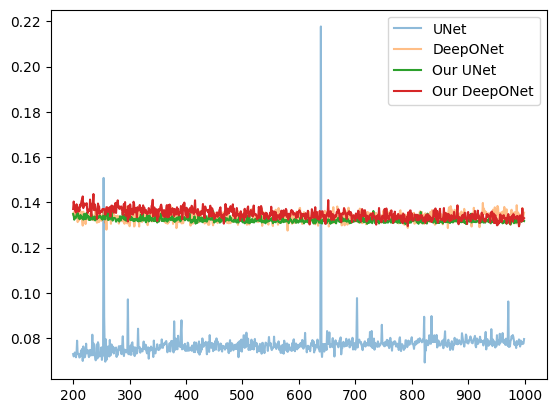

In [14]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save2[200:], label='UNet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save3[200:], label='DeepONet', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save23[200:], label='Our UNet')
plt.plot(range(1000)[200:], test_loss_save32[200:], label='Our DeepONet')
plt.legend()
plt.show()

In [15]:
# 평가
mse_base2 = evaluate(best_model2, test_loader, device)
mse_base3 = evaluate(best_model3, test_loader, device)
mse_study23 = evaluate(best_model23, test_loader, device)
mse_study32 = evaluate(best_model32, test_loader, device)

print(f"Model Base1 MSE: {mse_base2}")
print(f"Model Base3 MSE: {mse_base3}")
print(f"Model Study13 MSE: {mse_study23}")
print(f"Model Study31 MSE: {mse_study32}")

Model Base1 MSE: 0.06074379490954535
Model Base3 MSE: 0.12753387753452575
Model Study13 MSE: 0.13022062182426453
Model Study31 MSE: 0.1294126414826938


In [16]:
torch.cuda.empty_cache()
# Study Group 학습
model11a = copy.deepcopy(pretrained_model1).to(device)
model11b = copy.deepcopy(pretrained_model1).to(device)
optimizer11a = torch.optim.Adam(model11a.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer11b = torch.optim.Adam(model11b.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models11a = []
train_loss_save11a = []
test_loss_save11a = []
# fine_tuned_models11b = []
train_loss_save11b = []
test_loss_save11b = []
for epoch in tqdm(range(epochs)):
    model11a, model11b, weight11a, weight11b, loss11a, loss11b = studygroup(model11a, model11b, optimizer11a, optimizer11b, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save11a.append(loss11a)
    # fine_tuned_models23.append(weight23)
    test_loss11a = evaluate(model11a, test_loader, device)
    test_loss_save11a.append(test_loss11a)
    if epoch == 0:
        best_model11a = copy.deepcopy(model11a)
        best_weight11a = copy.deepcopy(weight11a)
    elif test_loss11a == min(test_loss_save11a):
        best_model11a = copy.deepcopy(model11a)
        best_weight11a = copy.deepcopy(weight11a)
        
    train_loss_save11b.append(loss11b)
    # fine_tuned_models11b.append(weight11b)
    test_loss11b = evaluate(model11b, test_loader, device)
    test_loss_save11b.append(test_loss11b)
    if epoch == 0:
        best_model11b = copy.deepcopy(model11b)
        best_weight11b = copy.deepcopy(weight11b)
    elif test_loss11b == min(test_loss_save11b):
        best_model11b = copy.deepcopy(model11b)
        best_weight11b = copy.deepcopy(weight11b)


100%|█████████████████████████████████████| 1000/1000 [1:11:16<00:00,  4.28s/it]


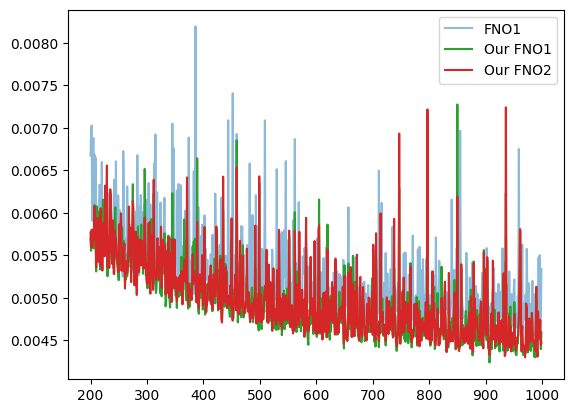

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save1[200:], label='FNO1', color='C0', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save11a[200:], label='Our FNO1', color='C2')
plt.plot(range(1000)[200:], test_loss_save11b[200:], label='Our FNO2', color='C3')
plt.legend()
plt.show()

In [18]:
# 평가
mse_base1 = evaluate(best_model1, test_loader, device)
mse_study11a = evaluate(best_model11a, test_loader, device)
mse_study11b = evaluate(best_model11b, test_loader, device)

print(f"Model Base1 MSE: {mse_base1}")
print(f"Model Study11a MSE: {mse_study11a}")
print(f"Model Study11b MSE: {mse_study11b}")

Model Base1 MSE: 0.004527100095791476
Model Study11a MSE: 0.004239993535780481
Model Study11b MSE: 0.004300025225217853


In [19]:
torch.cuda.empty_cache()
# Study Group 학습
model22a = copy.deepcopy(pretrained_model2).to(device)
model22b = copy.deepcopy(pretrained_model2).to(device)
optimizer22a = torch.optim.Adam(model22a.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer22b = torch.optim.Adam(model22b.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models22a = []
train_loss_save22a = []
test_loss_save22a = []
# fine_tuned_models22b = []
train_loss_save22b = []
test_loss_save22b = []
for epoch in tqdm(range(epochs)):
    model22a, model22b, weight22a, weight22b, loss22a, loss22b = studygroup(model22a, model22b, optimizer22a, optimizer22b, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save22a.append(loss22a)
    # fine_tuned_models22.append(weight22)
    test_loss22a = evaluate(model22a, test_loader, device)
    test_loss_save22a.append(test_loss22a)
    if epoch == 0:
        best_model22a = copy.deepcopy(model22a)
        best_weight22a = copy.deepcopy(weight22a)
    elif test_loss22a == min(test_loss_save22a):
        best_model22a = copy.deepcopy(model22a)
        best_weight22a = copy.deepcopy(weight22a)
        
    train_loss_save22b.append(loss22b)
    # fine_tuned_models22b.append(weight22b)
    test_loss22b = evaluate(model22b, test_loader, device)
    test_loss_save22b.append(test_loss22b)
    if epoch == 0:
        best_model22b = copy.deepcopy(model22b)
        best_weight22b = copy.deepcopy(weight22b)
    elif test_loss22b == min(test_loss_save22b):
        best_model22b = copy.deepcopy(model22b)
        best_weight22b = copy.deepcopy(weight22b)


100%|███████████████████████████████████████| 1000/1000 [43:42<00:00,  2.62s/it]


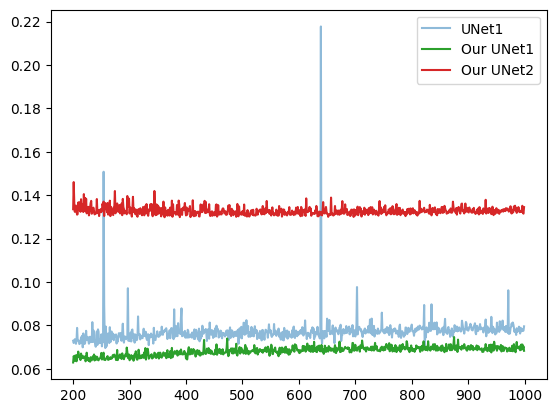

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save2[200:], label='UNet1', color='C0', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save22a[200:], label='Our UNet1', color='C2')
plt.plot(range(1000)[200:], test_loss_save22b[200:], label='Our UNet2', color='C3')
plt.legend()
plt.show()

In [21]:
# 평가
mse_base2 = evaluate(best_model2, test_loader, device)
mse_study22a = evaluate(best_model22a, test_loader, device)
mse_study22b = evaluate(best_model22b, test_loader, device)

print(f"Model Base2 MSE: {mse_base2}")
print(f"Model Study22a MSE: {mse_study22a}")
print(f"Model Study22b MSE: {mse_study22b}")

Model Base2 MSE: 0.06074379490954535
Model Study22a MSE: 0.06268936129552978
Model Study22b MSE: 0.12985112518072128


In [22]:
torch.cuda.empty_cache()
# Study Group 학습
model33a = copy.deepcopy(pretrained_model3).to(device)
model33b = copy.deepcopy(pretrained_model3).to(device)
optimizer33a = torch.optim.Adam(model33a.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer33b = torch.optim.Adam(model33b.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
# fine_tuned_models33a = []
train_loss_save33a = []
test_loss_save33a = []
# fine_tuned_models33b = []
train_loss_save33b = []
test_loss_save33b = []
for epoch in tqdm(range(epochs)):
    model33a, model33b, weight33a, weight33b, loss33a, loss33b = studygroup(model33a, model33b, optimizer33a, optimizer33b, criterion, train_loader, lr=1e-3, device=device)
    train_loss_save33a.append(loss33a)
    # fine_tuned_models33.append(weight33)
    test_loss33a = evaluate(model33a, test_loader, device)
    test_loss_save33a.append(test_loss33a)
    if epoch == 0:
        best_model33a = copy.deepcopy(model33a)
        best_weight33a = copy.deepcopy(weight33a)
    elif test_loss33a == min(test_loss_save33a):
        best_model33a = copy.deepcopy(model33a)
        best_weight33a = copy.deepcopy(weight33a)
        
    train_loss_save33b.append(loss33b)
    # fine_tuned_models33b.append(weight33b)
    test_loss33b = evaluate(model33b, test_loader, device)
    test_loss_save33b.append(test_loss33b)
    if epoch == 0:
        best_model33b = copy.deepcopy(model33b)
        best_weight33b = copy.deepcopy(weight33b)
    elif test_loss33b == min(test_loss_save33b):
        best_model33b = copy.deepcopy(model33b)
        best_weight33b = copy.deepcopy(weight33b)


100%|███████████████████████████████████████| 1000/1000 [03:57<00:00,  4.22it/s]


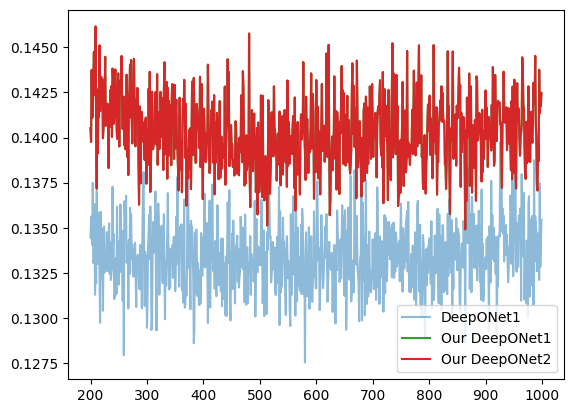

In [23]:
import matplotlib.pyplot as plt
plt.plot(range(1000)[200:], test_loss_save3[200:], label='DeepONet1', color='C0', alpha=0.5)
plt.plot(range(1000)[200:], test_loss_save33a[200:], label='Our DeepONet1', color='C2')
plt.plot(range(1000)[200:], test_loss_save33b[200:], label='Our DeepONet2', color='C3')
plt.legend()
plt.show()

In [24]:
# 평가
mse_base3 = evaluate(best_model3, test_loader, device)
mse_study33a = evaluate(best_model33a, test_loader, device)
mse_study33b = evaluate(best_model33b, test_loader, device)

print(f"Model Base3 MSE: {mse_base3}")
print(f"Model Study33a MSE: {mse_study33a}")
print(f"Model Study33b MSE: {mse_study33b}")

Model Base3 MSE: 0.12753387753452575
Model Study33a MSE: 0.1349107176065445
Model Study33b MSE: 0.1349107176065445
